<a href="https://colab.research.google.com/github/davione112/HateSpeechDetection/blob/main/Hate_speech_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Library

In [1]:
!pip install emot --upgrade
!pip install regex
!pip install vncorenlp
!pip install datasets
!pip install torch
!pip install pyvi
!pip install transformers==4.9.2
!pip install deplacy vncorenlp
!test -d VnCoreNLP || git clone --depth=1 https://github.com/vncorenlp/VnCoreNLP

In [2]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

--2021-09-07 15:24:00--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M  --.-KB/s    in 0.1s    

2021-09-07 15:24:01 (216 MB/s) - ‘VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2021-09-07 15:24:01--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respon

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel,Trainer, TrainingArguments,AutoModelForSequenceClassification,DataCollatorWithPadding
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from transformers.trainer_callback import EarlyStoppingCallback
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report
from itertools import groupby
import torch
import regex as re
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO 
from vncorenlp import VnCoreNLP
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from pyvi import ViTokenizer, ViPosTagger,ViUtils
from sklearn.linear_model import LogisticRegression
vncorenlp = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 
%cd /content/drive/MyDrive/hate_speech_detection

/content/drive/MyDrive/hate_speech_detection


#Data Loader

In [4]:
train = pd.read_csv("vihsd/vihsd/train.csv",index_col=False)
test = pd.read_csv("vihsd/vihsd/test.csv",index_col=False)
dev = pd.read_csv("vihsd/vihsd/dev.csv",index_col=False)

In [5]:
train.head(5)

,free_text,label_id
0,Em được làm fan cứng luôn rồi nè ❤️ reaction q...,0
1,Đúng là bọn mắt híp lò xo thụt :))) bên việt n...,2
2,Đậu Văn Cường giờ giống thằng sida hơn à,0
3,CÔN ĐỒ CỤC SÚC VÔ NHÂN TÍNH ĐỀ NGHI VN. NHÀ NƯ...,2
4,Từ lý thuyết đến thực hành là cả 1 câu chuyện ...,0


#Overview

In [6]:
print(train.shape,dev.shape,test.shape)

(24048, 2) (2672, 2) (6680, 2)


## Remove duplicate

In [7]:
dev = dev.drop_duplicates(keep='last').reset_index(drop=True)
train = train.drop_duplicates(keep='last').reset_index(drop=True)
print(train.shape,dev.shape,test.shape)

(22692, 2) (2651, 2) (6680, 2)


##Remove missing values

In [8]:
train = train.dropna().reset_index(drop=True)
dev = dev.dropna().reset_index(drop=True)
print(train.shape,dev.shape,test.shape)

(22690, 2) (2651, 2) (6680, 2)


##Count label

In [9]:
def count_label(dataset):
  count = (train['label_id'].value_counts())
  sns.set()
  # labels = data.keys()
  count.plot(kind='pie', title='Number of label in training set', figsize=[8,8], startangle=90, shadow=True,
             colors=['#EAB315','#F1CB5F','#F7E4AF'],
          autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*count.sum()))
  plt.show()

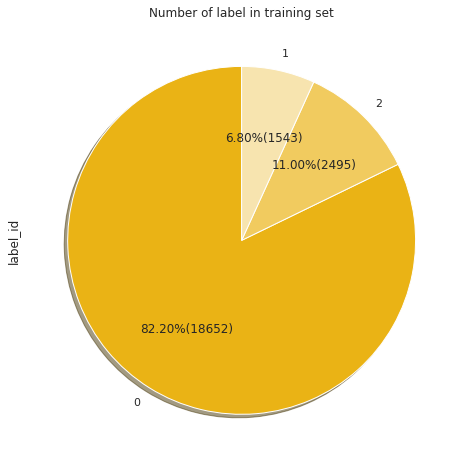

In [10]:
count_label(train)

##Length of comment

In [11]:
def length(dataset):
  l = []
  for i in train['free_text']:
    l.append(len(str(i).split()))
  l = pd.DataFrame(l, columns=['Length'])  
  l = (l.value_counts())
  sns.set()
  l.plot(kind='area', title='Length of comments in training set', figsize=[8,8], colormap='summer',
          )
  plt.show()

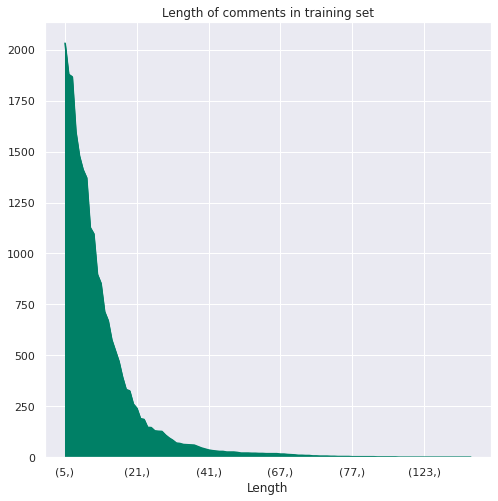

In [12]:
length(train)

##Vocab

In [13]:
def create_vocab(dataset):
  text = []
  for sentence in dataset['free_text']:
    text.extend(str(sentence).split())
  vocab = set(text)
  # print(groupby(text))
  #print(len(vocab),vocab)
  df = pd.DataFrame(list(vocab))
  return df

In [14]:
text = []
for sentence in train['free_text']:
  text.extend(str(sentence).split())

In [15]:
vocab = create_vocab(train)
vocab.to_csv('vocab.csv')

#Preprocessing

##Normalize Unicode

In [16]:
"""
    Start section: Chuyển câu văn về kiểu gõ telex khi không bật Unikey
    Ví dụ: thủy = thuyr, tượng = tuwowngj
"""
bang_nguyen_am = [['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a'],
                  ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
                  ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
                  ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e'],
                  ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
                  ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i'],
                  ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o'],
                  ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
                  ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
                  ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u'],
                  ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
                  ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y']]
bang_ky_tu_dau = ['', 'f', 's', 'r', 'x', 'j']

nguyen_am_to_ids = {}

for i in range(len(bang_nguyen_am)):
    for j in range(len(bang_nguyen_am[i]) - 1):
        nguyen_am_to_ids[bang_nguyen_am[i][j]] = (i, j)


def vn_word_to_telex_type(word):
    dau_cau = 0
    new_word = ''
    for char in word:
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x == -1:
            new_word += char
            continue
        if y != 0:
            dau_cau = y
        new_word += bang_nguyen_am[x][-1]
    new_word += bang_ky_tu_dau[dau_cau]
    return new_word


def vn_sentence_to_telex_type(sentence):
    """
    Chuyển câu tiếng việt có dấu về kiểu gõ telex.
    :param sentence:
    :return:
    """
    words = sentence.split()
    for index, word in enumerate(words):
        words[index] = vn_word_to_telex_type(word)
    return ' '.join(words)


"""
    End section: Chuyển câu văn về kiểu gõ telex khi không bật Unikey
"""
# vn_sentence_to_telex_type('tượng')

'\n    End section: Chuyển câu văn về kiểu gõ telex khi không bật Unikey\n'

In [17]:
#convert to Unicode
uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"
 
 
def loaddicchar():
    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic
 
 
dicchar = loaddicchar()
 
 
def convert_unicode(text):
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], text)

##Normalize dấu

In [18]:
def chuan_hoa_dau_tu_tieng_viet(word):
    if not is_valid_vietnam_word(word):
        return word
 
    chars = list(word)
    dau_cau = 0
    nguyen_am_index = []
    qu_or_gi = False
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x == -1:
            continue
        elif x == 9:  # check qu
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True
        elif x == 5:  # check gi
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True
        if y != 0:
            dau_cau = y
            chars[index] = bang_nguyen_am[x][0]
        if not qu_or_gi or index != 1:
            nguyen_am_index.append(index)
    if len(nguyen_am_index) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                x, y = nguyen_am_to_ids.get(chars[1])
                chars[1] = bang_nguyen_am[x][dau_cau]
            else:
                x, y = nguyen_am_to_ids.get(chars[2], (-1, -1))
                if x != -1:
                    chars[2] = bang_nguyen_am[x][dau_cau]
                else:
                    chars[1] = bang_nguyen_am[5][dau_cau] if chars[1] == 'i' else bang_nguyen_am[9][dau_cau]
            return ''.join(chars)
        return word
 
    for index in nguyen_am_index:
        x, y = nguyen_am_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = bang_nguyen_am[x][dau_cau]
            # for index2 in nguyen_am_index:
            #     if index2 != index:
            #         x, y = nguyen_am_to_ids[chars[index]]
            #         chars[index2] = bang_nguyen_am[x][0]
            return ''.join(chars)
 
    if len(nguyen_am_index) == 2:
        if nguyen_am_index[-1] == len(chars) - 1:
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            chars[nguyen_am_index[0]] = bang_nguyen_am[x][dau_cau]
            # x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            # chars[nguyen_am_index[1]] = bang_nguyen_am[x][0]
        else:
            # x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            # chars[nguyen_am_index[0]] = bang_nguyen_am[x][0]
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
    else:
        # x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
        # chars[nguyen_am_index[0]] = bang_nguyen_am[x][0]
        x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
        chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
        # x, y = nguyen_am_to_ids[chars[nguyen_am_index[2]]]
        # chars[nguyen_am_index[2]] = bang_nguyen_am[x][0]
    return ''.join(chars)
 
 
def is_valid_vietnam_word(word):
    chars = list(word)
    nguyen_am_index = -1
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x != -1:
            if nguyen_am_index == -1:
                nguyen_am_index = index
            else:
                if index - nguyen_am_index != 1:
                    return False
                nguyen_am_index = index
    return True
 
 
def chuan_hoa_dau_cau_tieng_viet(sentence):
    """
        Chuyển câu tiếng việt về chuẩn gõ dấu kiểu cũ.
        :param sentence:
        :return:
        """
    sentence = sentence.lower()
    words = sentence.split()
    for index, word in enumerate(words):
        cw = re.sub(r'(^\p{P}*)([p{L}.]*\p{L}+)(\p{P}*$)', r'\1/\2/\3', word).split('/')
        # print(cw)
        if len(cw) == 3:
            cw[1] = chuan_hoa_dau_tu_tieng_viet(cw[1])
        words[index] = ''.join(cw)
    return ' '.join(words)
 
 
"""
    End section: Chuyển câu văn về cách gõ dấu kiểu cũ: dùng òa úy thay oà uý
    Xem tại đây: https://vi.wikipedia.org/wiki/Quy_tắc_đặt_dấu_thanh_trong_chữ_quốc_ngữ
"""
if __name__ == '__main__':
    print(chuan_hoa_dau_cau_tieng_viet('anh hoà, đang làm.. gì'))

anh hòa, đang làm.. gì


In [20]:
def check_space(text):#check space in string 
  for i in range(len(text)):
    if text[i]==' ':
      return True
  return False
abb_dict_1=[]
abb_dict_2=[]
abb_dict = pd.read_excel('abbreviation_dictionary_vn.xlsx', sheet_name='Sheet1')
for i in range(abb_dict.shape[0]):
  word = abb_dict['abbreviation'][i]
  if (check_space(word)):
    abb_dict_2.append([abb_dict.at[i,'abbreviation'],abb_dict.at[i,'meaning']])# more 1 word
  else:
    abb_dict_1.append([abb_dict.at[i,'abbreviation'],abb_dict.at[i,'meaning']])# equal 1 word
abb_dict_1 = pd.DataFrame(abb_dict_1, columns=['abbreviation','meaning'])
abb_dict_2 = pd.DataFrame(abb_dict_2, columns=['abbreviation','meaning'])
abb_dict_1.to_excel('abb_dict_1.xlsx')
abb_dict_2.to_excel('abb_dict_2.xlsx')

In [27]:
# Remove emoji and emoticons
def emo(text):
  for emot in UNICODE_EMOJI:
    text = str(text).replace(emot, '')
  # for emot in EMOTICONS_EMO:
  #   text = str(text).replace(emot, '')  
  text = re.sub('  +',' ',text).strip() 
  return text  
#Remove url
def url(text):
  # url_pattern = re.compile(r'https?://\S+|www\.\S+')
  # text = url_pattern.sub(r'', str(text))
  text = re.sub(r'https?://\S+|www\.\S+', ' ',str(text))
  text = re.sub('  +',' ',text).strip()
  return text
#remove special character
def special_character(text):
  text = re.sub('[0-9]'," number ",text)
  text = re.sub("[~!@#$%^&*()_+{}“”|:\"<>?`´\-=[\]\;'\\\/.,]"," ",text)
  text = re.sub('  +',' ',text).strip()
  return text
#normalize repeated characters
def repeated_character(text):
  text = re.sub(r'(\w)\1+', r'\1', text) 
  text = re.sub('  +',' ',text).strip()
  return text
def mail(text):
  text = re.sub(r'[^@]+@[^@]+\.[^@]+',' ', text) 
  text = re.sub('  +',' ',text).strip()
  return text
#remove mention tag and hashtag
def tag(text):
  text = re.sub(r"(?:\@|\#|\://)\S+", " ", text) 
  text = re.sub('  +',' ',text).strip()
  return text
# """Remove all mixed words and numbers"""
def mixed_word_number(text):
  text = ' '.join(s for s in text.split() if not any(c.isdigit() for c in s))
  text = re.sub('  +',' ',text).strip()
  return text
#remove hidden string 
def hidden_character(text):
  text = re.sub("[^{}]+".format(printable), " ", text)
  text = re.sub('  +',' ',text).strip()
  return text
#tokenize by lib Pyvi
def tokenize_by_lib(text):
    text = ViTokenizer.tokenize(text)
    return text
#Tokenize by space
def tokenize_by_space(text):
  text = text.split() 
  return text
# """Read file stop words """
STOPWORDS = 'vietnamese-stopwords-dash.txt'
with open(STOPWORDS, "r") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stop_words = set(stopwords)
# """Filter stop words """
def filter_stop_words(text):
    new_sent = [word for word in text.split() if word not in stop_words]
    sentence = ' '.join(new_sent)        
    return sentence
def convert_emoji(text):
  text = text.replace(':)','\U0001F642')#1
  text = text.replace('=)','\U0001F60A')#2
  text = text.replace(':(','\U0001F641')#3
  text = text.replace(':v','\U0001F606')#4
  text = text.replace('-_-','\U0001F611')#5
  text = text.replace(':3','\U0001F619')#6
  text = text.replace('<3','\u2764\uFE0F')#7
  text = text.replace('@@','\u2764\uFE0F')#8
  text = text.replace(':<','\U0001F600')#9
  text = text.replace(':>','\U0001F61D')#10
  text = text.replace('=]','\U0001F601')#11  
  text = text.replace(':">','\U0001F61C')#12
  text = text.replace(':D','\U0001F601')#13
  text = text.replace(':*','\U0001F601')#14
  text = re.sub('  +',' ',text).strip()
  return text
abb_dict_1 = pd.read_excel("abb_dict_1.xlsx")
abb_dict_1 = abb_dict_1.drop(columns=['Unnamed: 0'])
def abbreviation_1(text):#len word equal 1
  for word in text.split():
    for i in range(abb_dict_1.shape[0]):
      if str(abb_dict_1.at[i,'abbreviation']) == str(word):
        word = str(abb_dict_1.at[i,'meaning']) 
  text = re.sub('  +',' ',text).strip()
  return text  
abb_dict_2 = pd.read_excel("abb_dict_2.xlsx")
abb_dict_2 = abb_dict_2.drop(columns=['Unnamed: 0'])
def abbreviation_2(text):#len word >2
  for i in range(abb_dict_2.shape[0]):
    text = text.replace(abb_dict_2.at[i,'abbreviation'], abb_dict_2.at[i,'meaning'])
  text = re.sub('  +',' ',text).strip()
  return text  
 

In [ ]:
abb_dict_2

In [ ]:
for i in range(abb_dict_2.shape[0]):
  print(abb_dict_2.at[i,'0'])

In [ ]:
print(':)','\U0001F642','<3','\u2764\uFE0F',':3','\U0001F619','-_-','\U0001F611',':v','\U0001F606',':(','\U0001F641','=)','\U0001F60A')
print('@@','\U0001F635',':D','\U0001F600',':>','\U0001F61D','=]','\U0001F601',':">','\U0001F61C',':D','\U0001F601')

In [29]:
# abbreviation_1(abbreviation_2('Nói quá đúng ka ka kk, chỉ buồn con người VN hiện giờ đã quá sợ hãi trước sự tàn ác của cs nên họ bịt tai ,bịt mắt ,bịt miệng trước nỗi đau của đồng bào ,đồng loại nhưng họ ko hiểu rằng "hôm nay là chuyện đã xãy ra với anh ấy , ngay mai nó sẽ xảy ra là chính mình" . Bởi thế có bịt tai ,bịt mắt cũng vô ích , hãy liên kết để hành động vì sự thật ,vì lẽ phải.'))

'Nói quá đúng ha ha kk, chỉ buồn con người VN hiện giờ đã quá sợ hãi trước sự tàn ác của cs nên họ bịt tai ,bịt mắt ,bịt miệng trước nỗi đau của đồng bào ,đồng loại nhưng họ ko hiểu rằng "hôm nay là chuyện đã xãy ra với anh ấy , ngay mai nó sẽ xảy ra là chính mình" . Bởi thế có bịt tai ,bịt mắt cũng vô ích , hãy liên kết để hành động vì sự thật ,vì lẽ phải.'

## preprocessing

In [30]:
def preprocessing(dataset):
  dataset['free_text'] = dataset['free_text'].str.lower() 
  dataset['free_text'] = dataset['free_text'].apply(abbreviation_2)
  dataset['free_text'] = dataset['free_text'].apply(convert_emoji)
  dataset['free_text'] = dataset['free_text'].apply(url)
  dataset['free_text'] = dataset['free_text'].apply(mail)
  # dataset['free_text'] = dataset['free_text'].apply(emo) #remove emo
  dataset['free_text'] = dataset['free_text'].apply(tag)#remove tag
  dataset['free_text'] = dataset['free_text'].apply(convert_unicode)
  dataset['free_text'] = dataset['free_text'].apply(chuan_hoa_dau_cau_tieng_viet)
  dataset['free_text'] = dataset['free_text'].apply(repeated_character)  
  dataset['free_text'] = dataset['free_text'].apply(special_character)
  # dataset['free_text'] = dataset['free_text'].apply(hidden_character)
  dataset['free_text'] = dataset['free_text'].apply(abbreviation_1)  
  # dataset['free_text'] = dataset['free_text'].apply(mixed_word_number)
  # dataset['free_text'] = dataset['free_text'].apply(tokenize_by_lib)
  # dataset['free_text'] = dataset['free_text'].apply(tokenize_by_space)#space
  # dataset['free_text'] = dataset['free_text'].apply(filter_stop_words)
  return dataset

In [31]:
train = preprocessing(train)
dev = preprocessing(dev)
test = preprocessing(test)

NameError: ignored

In [ ]:
# print(train.shape,dev.shape,test.shape)
# dev = dev.drop_duplicates(keep='last').dropna().reset_index(drop=True)
# train = train.drop_duplicates(keep='last').dropna().reset_index(drop=True)
# print(train.shape,dev.shape,test.shape)

In [ ]:
# vocab = create_vocab(train)
# print(len(vocab))
# vocab.to_csv('preprocessed_data/vocab.csv')

##Save dataset

In [ ]:
train.to_csv("preprocessed_data/train.csv")
dev.to_csv("preprocessed_data/dev.csv")
test.to_csv("preprocessed_data/test.csv")

#Training

##Load dataset

In [ ]:
preprocessed_train = pd.read_csv("preprocessed_data/train.csv")
preprocessed_dev = pd.read_csv("preprocessed_data/dev.csv")
preprocessed_test = pd.read_csv("preprocessed_data/test.csv")

In [ ]:
X_train = preprocessed_train['free_text']
y_train = preprocessed_train['label_id'].values

X_dev = preprocessed_dev['free_text']
y_dev = preprocessed_dev['label_id'].values

X_test = preprocessed_test['free_text']
y_test = preprocessed_test['label_id'].values

##ML

## BOW

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
X_train = pd.concat([X_train, X_dev], ignore_index=True)
y_train = np.concatenate((y_train,y_dev),axis = 0)
CountVec = CountVectorizer(ngram_range=(1,5),max_features=len(vocab))
X_train = CountVec.fit_transform(X_train.values.astype('U'))
X_test = CountVec.transform(X_test.values.astype('U'))

## TF-IDF

In [ ]:
X_train = pd.concat([X_train, X_dev], ignore_index=True)
y_train = np.concatenate((y_train,y_dev),axis = 0)
Tfidf_vect = TfidfVectorizer(max_features=len(vocab))
X_train = Tfidf_vect.fit_transform(X_train.values.astype('U'))
X_test = Tfidf_vect.transform(X_test.values.astype('U'))

## Find best hyperparameter

###LR

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
param_grid = {  'C': [ 0.1, 1, 10, 100],
              "penalty":["l1","l2"]
              }
clf = LogisticRegression()#class_weight = 'balanced')

scoring =make_scorer(f1_score, average='macro')
g_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                        cv = 5, 
                        # n_jobs = 1, 
                        # verbose = 0, 
                        return_train_score=True,
                        scoring = scoring
                        )
g_search.fit(X_train, y_train)

print(g_search.best_params_)

###SVM

In [ ]:
# parameters = {'kernel':['linear', 'rbf'], 
#               'C':[1, 10, 100,1000,10000],
#               'gamma': [10,1, 0.1, 0.01, 0.001],
#               }
# svc = svm.SVC()
# scoring =make_scorer(f1_score, average='macro')
# g_search = GridSearchCV(svc, parameters,scoring=scoring,cv = 5, 
#                         # n_jobs = 1, 
#                         # verbose = 0, 
#                         return_train_score=True,)
# g_search.fit(X_train, y_train)
# print(g_search.best_params_)


##LR

In [ ]:
# SVM = svm.SVC(C=100, kernel='rbf', gamma=0.01).fit(X_train, y_train)
# y_pred = SVM.predict(X_test)
# print(classification_report(y_pred, y_test, digits = 4))
clf = LogisticRegression(C=10, penalty= 'l2').fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_pred, y_test, digits = 4))

##SVM

##Find best max-features

In [ ]:
# for max_features in range(10000, len(vocab),2000):
#   print('max_features',max_features)
#   X_train = train['free_text']
#   y_train = train['label_id'].values
#   X_dev = dev['free_text']
#   y_dev = dev['label_id'].values
#   X_test = test['free_text']
#   y_test = test['label_id'].values
#   X_train = pd.concat([X_train, X_dev], ignore_index=True)
#   y_train = np.concatenate((y_train,y_dev),axis = 0)
#   Tfidf_vect = TfidfVectorizer(max_features=max_features)
#   X_train = Tfidf_vect.fit_transform(X_train.values.astype('U'))
#   X_test = Tfidf_vect.transform(X_test.values.astype('U'))
#   SVM = svm.SVC(C=10, kernel='linear', degree=3, gamma='auto')
#   SVM.fit(X_train, y_train)
#   y_pred = SVM.predict(X_test)
#   print(classification_report(y_pred, y_test, digits = 4))
#   clf = LogisticRegression(random_state=0,class_weight = 'balanced').fit(X_train, y_train)
#   y_pred = clf.predict(X_test)
#   print(classification_report(y_pred, y_test, digits = 4))

In [ ]:
#0.5706 0.6042 lower + tokenize
#0.5710 58.81 replace url to <url>
#0.0.6033  0.0.6052      

##Bert multi case

In [ ]:
class BuildDataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, X, y, max_len):
        self.tokenizer = tokenizer
        self.comment_text = X
        self.targets = y
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())
        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding=True,
            truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'attention_mask': torch.tensor(mask, dtype=torch.long),
            'labels': torch.tensor(self.targets[index], dtype=torch.long)
        }


In [ ]:
def compute_metrics(p):    
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='macro')
    precision = precision_score(y_true=labels, y_pred=pred, average='macro')
    f1 = f1_score(y_true=labels, y_pred=pred, average='macro')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1} 

In [ ]:
model_checkpoint = 'bert-base-multilingual-cased'
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint,num_labels=3)
tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
# Chuan bi data
MAX_LEN = 100
training_set = BuildDataset(tokenizer, X_train, y_train, max_len = MAX_LEN)
test_set = BuildDataset(tokenizer,  X_test, y_test, max_len = MAX_LEN)
dev_set = BuildDataset(tokenizer,  X_dev, y_dev, max_len = MAX_LEN)

In [ ]:
#  torch.cuda.memory_summary(device=None, abbreviated=False)

In [ ]:
# Chuan bi mo hinh
data_collator = DataCollatorWithPadding(tokenizer)
training_args = TrainingArguments(
    output_dir='/results',          
    num_train_epochs = 8,              
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    learning_rate = 1e-5,  
    warmup_steps=1000,   
    save_steps=1000,         
    weight_decay=0.01,
    logging_dir = '/logs',
    evaluation_strategy ='steps',
    eval_steps = 500,
    save_total_limit = 5,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,                         
    args=training_args, 
    data_collator =data_collator,                 
    train_dataset=training_set,         
    eval_dataset=dev_set,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)
trainer.train()

###Predict

In [ ]:
trainer.evaluate()
model_path = "multi-bert-base-cased"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=3)
tokenizer = BertTokenizer.from_pretrained(model_path)
predictions, label_ids ,metrics =trainer.predict(test_set)
y_pred = np.argmax(predictions, axis=1)
print(classification_report( y_test, y_pred, digits = 4))

In [ ]:
def get_prediction(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=MAX_LEN, return_tensors="pt")#.to("cuda")
    outputs = model(**inputs)
    probs = outputs[0].softmax(1)
    return int(probs.argmax())
text = "thằng chó mất dạy, cmm nhá, vl, dmcs"
print(get_prediction(text))

##Bert multi uncased

In [ ]:
model_checkpoint = 'bert-base-multilingual-uncased'
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint,num_labels=3)
tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
# Chuan bi data
MAX_LEN = 100
training_set = BuildDataset(tokenizer, X_train, y_train, max_len = MAX_LEN)
test_set = BuildDataset(tokenizer,  X_test, y_test, max_len = MAX_LEN)
dev_set = BuildDataset(tokenizer,  X_dev, y_dev, max_len = MAX_LEN)

In [ ]:
# Chuan bi mo hinh
data_collator = DataCollatorWithPadding(tokenizer)
training_args = TrainingArguments(
    output_dir='/results',          
    num_train_epochs = 8,              
    per_device_train_batch_size=64 ,
    per_device_eval_batch_size=32,
    learning_rate = 1e-5,  
    warmup_steps=1000,   
    save_steps=1000,         
    weight_decay=0.01,
    logging_dir = '/logs',
    evaluation_strategy ='steps',
    eval_steps = 500,
    save_total_limit = 5,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,                         
    args=training_args, 
    data_collator =data_collator,                 
    train_dataset=training_set,         
    eval_dataset=dev_set,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)
trainer.train()

In [ ]:
trainer.evaluate()
model_path = "multi-bert-base-uncased"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=3)
tokenizer = BertTokenizer.from_pretrained(model_path)
predictions, label_ids ,metrics =trainer.predict(test_set)
y_pred = np.argmax(predictions, axis=1)
print(f1_score(label_ids, y_pred, average='macro'))
print(accuracy_score(label_ids, y_pred))

In [ ]:
def get_prediction(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=MAX_LEN, return_tensors="pt")#.to("cuda")
    outputs = model(**inputs)
    probs = outputs[0].softmax(1)
    return int(probs.argmax())
text = "thằng chó mất dạy, cmm nhá, vl, dmcs"
print(get_prediction(text))

## h

In [ ]:
re.sub('[^!-~]+',' ','trời đang dần sáng @# !').strip()